In [18]:
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from tqdm import tqdm

In [2]:
dir_path = "C:/Users/joann/Documents/PlantVillage-Dataset/raw/color"

In [3]:
data = []
label_names = []
distinct_labels = set()
directory = os.listdir(dir_path)
for subdir in directory:
    subdir_path = os.path.join(dir_path, subdir)
    subdirectory = os.listdir(subdir_path)
    for image in subdirectory:
        img = np.asarray(Image.open(os.path.join(subdir_path, image)))
        if img.shape == (256, 256, 3):
            data.append(img)
            label_names.append(subdir)
            distinct_labels.add(subdir)
data = np.array(data)
label_names = np.array(label_names)
distinct_labels = sorted(distinct_labels)

In [4]:
print(data.shape)
print(label_names.shape)

(54304, 256, 256, 3)
(54304,)


In [5]:
labels = []
for i in label_names:
    labels.append(distinct_labels.index(i))
labels = np.array(labels).astype(np.int64)
print(labels)

[ 0  0  0 ... 35 35 35]


In [6]:
torch.cuda.is_available()

True

In [7]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.20)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.10)

In [8]:
class PlantVillageDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(180),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

loaders = {'train': DataLoader(PlantVillageDataset(X_train, y_train, transform=data_transforms['train']), shuffle=True, batch_size=32), \
           'val': DataLoader(PlantVillageDataset(X_val, y_val, transform=data_transforms['val']), shuffle=True, batch_size=32), \
           'test': DataLoader(PlantVillageDataset(X_test, y_test, transform=data_transforms['val']), shuffle=True, batch_size=32)}
dataset_sizes = {'train': len(X_train), 'val': len(X_val), 'test': len(X_test)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
losses = {'train': [], 'val': []}
accs = {'train': [], 'val': []}

In [19]:
def train(model, criterion, optimizer, scheduler):
    model.train()
    total_loss = 0.0
    total_correct = 0

    for inputs, labels in tqdm(loaders['train']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.enable_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total_correct += torch.sum(preds == labels.data)
    scheduler.step()

    train_loss = total_loss / dataset_sizes['train']
    train_acc = total_correct.cpu() / dataset_sizes['train']
    losses['train'].append(train_loss)
    accs['train'].append(train_acc)
    return train_loss, train_acc

In [11]:
def val(model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0

    for inputs, labels in loaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total_loss += loss.item() * inputs.size(0)
        total_correct += torch.sum(preds == labels.data)

    val_loss = total_loss / dataset_sizes['val']
    val_acc = total_correct.cpu() / dataset_sizes['val']
    losses['val'].append(val_loss)
    accs['val'].append(val_acc)
    return val_loss, val_acc

In [14]:
def test(model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    true_labels = []
    pred_labels = []

    for inputs, labels in loaders['test']:
        inputs = inputs.to(device)
        true_labels.extend(labels)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            pred_labels.extend(preds.cpu())
            loss = criterion(outputs, labels)

        total_loss += loss.item() * inputs.size(0)
        total_correct += torch.sum(preds == labels.data)

    test_loss = total_loss / dataset_sizes['test']
    test_acc = total_correct / dataset_sizes['test']
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
    return test_loss, test_acc, conf_matrix, precision, recall, f1

In [15]:
model = models.resnet18(weights='IMAGENET1K_V1')

In [16]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(distinct_labels))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
num_epochs = 25
best_model_params_path = "resnetcheckpoints/best_model_params.pt"

torch.save(model.state_dict(), best_model_params_path)
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    train_loss, train_acc = train(model, criterion, optimizer, scheduler)
    val_loss, val_acc = val(model, criterion)

    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), best_model_params_path)
    print()

print(f'Best Validation Acc: {best_acc:4f}')

Epoch 1/25
----------


100%|██████████| 1358/1358 [11:58<00:00,  1.89it/s]


Train Loss: 0.5186 Acc: 0.8343
Validation Loss: 0.4688 Acc: 0.8446

Epoch 2/25
----------


100%|██████████| 1358/1358 [13:06<00:00,  1.73it/s]


Train Loss: 0.2624 Acc: 0.9146
Validation Loss: 0.3534 Acc: 0.8966

Epoch 3/25
----------


100%|██████████| 1358/1358 [13:11<00:00,  1.72it/s]


Train Loss: 0.2075 Acc: 0.9322
Validation Loss: 0.1797 Acc: 0.9421

Epoch 4/25
----------


100%|██████████| 1358/1358 [13:08<00:00,  1.72it/s]


Train Loss: 0.1741 Acc: 0.9437
Validation Loss: 0.1208 Acc: 0.9608

Epoch 5/25
----------


100%|██████████| 1358/1358 [13:11<00:00,  1.71it/s]


Train Loss: 0.1496 Acc: 0.9519
Validation Loss: 0.1061 Acc: 0.9678

Epoch 6/25
----------


100%|██████████| 1358/1358 [13:10<00:00,  1.72it/s]


Train Loss: 0.1389 Acc: 0.9537
Validation Loss: 0.0897 Acc: 0.9721

Epoch 7/25
----------


100%|██████████| 1358/1358 [13:09<00:00,  1.72it/s]


Train Loss: 0.1235 Acc: 0.9589
Validation Loss: 0.1195 Acc: 0.9602

Epoch 8/25
----------


100%|██████████| 1358/1358 [13:09<00:00,  1.72it/s]


Train Loss: 0.0474 Acc: 0.9844
Validation Loss: 0.0302 Acc: 0.9904

Epoch 9/25
----------


100%|██████████| 1358/1358 [13:11<00:00,  1.72it/s]


Train Loss: 0.0352 Acc: 0.9881
Validation Loss: 0.0276 Acc: 0.9917

Epoch 10/25
----------


100%|██████████| 1358/1358 [13:11<00:00,  1.72it/s]


Train Loss: 0.0297 Acc: 0.9907
Validation Loss: 0.0243 Acc: 0.9923

Epoch 11/25
----------


100%|██████████| 1358/1358 [13:11<00:00,  1.72it/s]


Train Loss: 0.0271 Acc: 0.9908
Validation Loss: 0.0236 Acc: 0.9935

Epoch 12/25
----------


100%|██████████| 1358/1358 [13:13<00:00,  1.71it/s]


Train Loss: 0.0251 Acc: 0.9918
Validation Loss: 0.0224 Acc: 0.9938

Epoch 13/25
----------


100%|██████████| 1358/1358 [13:10<00:00,  1.72it/s]


Train Loss: 0.0228 Acc: 0.9920
Validation Loss: 0.0244 Acc: 0.9923

Epoch 14/25
----------


100%|██████████| 1358/1358 [13:11<00:00,  1.72it/s]


Train Loss: 0.0216 Acc: 0.9930
Validation Loss: 0.0220 Acc: 0.9935

Epoch 15/25
----------


100%|██████████| 1358/1358 [13:10<00:00,  1.72it/s]


Train Loss: 0.0184 Acc: 0.9937
Validation Loss: 0.0174 Acc: 0.9951

Epoch 16/25
----------


100%|██████████| 1358/1358 [13:09<00:00,  1.72it/s]


Train Loss: 0.0166 Acc: 0.9944
Validation Loss: 0.0174 Acc: 0.9950

Epoch 17/25
----------


100%|██████████| 1358/1358 [13:07<00:00,  1.73it/s]


Train Loss: 0.0166 Acc: 0.9944
Validation Loss: 0.0166 Acc: 0.9955

Epoch 18/25
----------


100%|██████████| 1358/1358 [13:11<00:00,  1.72it/s]


Train Loss: 0.0163 Acc: 0.9947
Validation Loss: 0.0168 Acc: 0.9953

Epoch 19/25
----------


100%|██████████| 1358/1358 [13:16<00:00,  1.70it/s]


Train Loss: 0.0158 Acc: 0.9949
Validation Loss: 0.0163 Acc: 0.9952

Epoch 20/25
----------


100%|██████████| 1358/1358 [13:10<00:00,  1.72it/s]


Train Loss: 0.0161 Acc: 0.9945
Validation Loss: 0.0170 Acc: 0.9955

Epoch 21/25
----------


100%|██████████| 1358/1358 [13:09<00:00,  1.72it/s]


Train Loss: 0.0145 Acc: 0.9953
Validation Loss: 0.0170 Acc: 0.9956

Epoch 22/25
----------


100%|██████████| 1358/1358 [13:08<00:00,  1.72it/s]


Train Loss: 0.0150 Acc: 0.9950
Validation Loss: 0.0159 Acc: 0.9956

Epoch 23/25
----------


100%|██████████| 1358/1358 [13:08<00:00,  1.72it/s]


Train Loss: 0.0150 Acc: 0.9954
Validation Loss: 0.0162 Acc: 0.9960

Epoch 24/25
----------


100%|██████████| 1358/1358 [13:08<00:00,  1.72it/s]


Train Loss: 0.0152 Acc: 0.9950
Validation Loss: 0.0172 Acc: 0.9953

Epoch 25/25
----------


100%|██████████| 1358/1358 [13:09<00:00,  1.72it/s]


Train Loss: 0.0134 Acc: 0.9958
Validation Loss: 0.0170 Acc: 0.9950

Best Validation Acc: 0.996010


In [21]:
test_loss, test_acc, conf_matrix, precision, recall, f1 = test(model, criterion)

Test Loss: 0.018061
Test Acc: 0.994480
Precision: 0.9948139329328789
Recall: 0.9944802207911684
F1: 0.9945378965591463


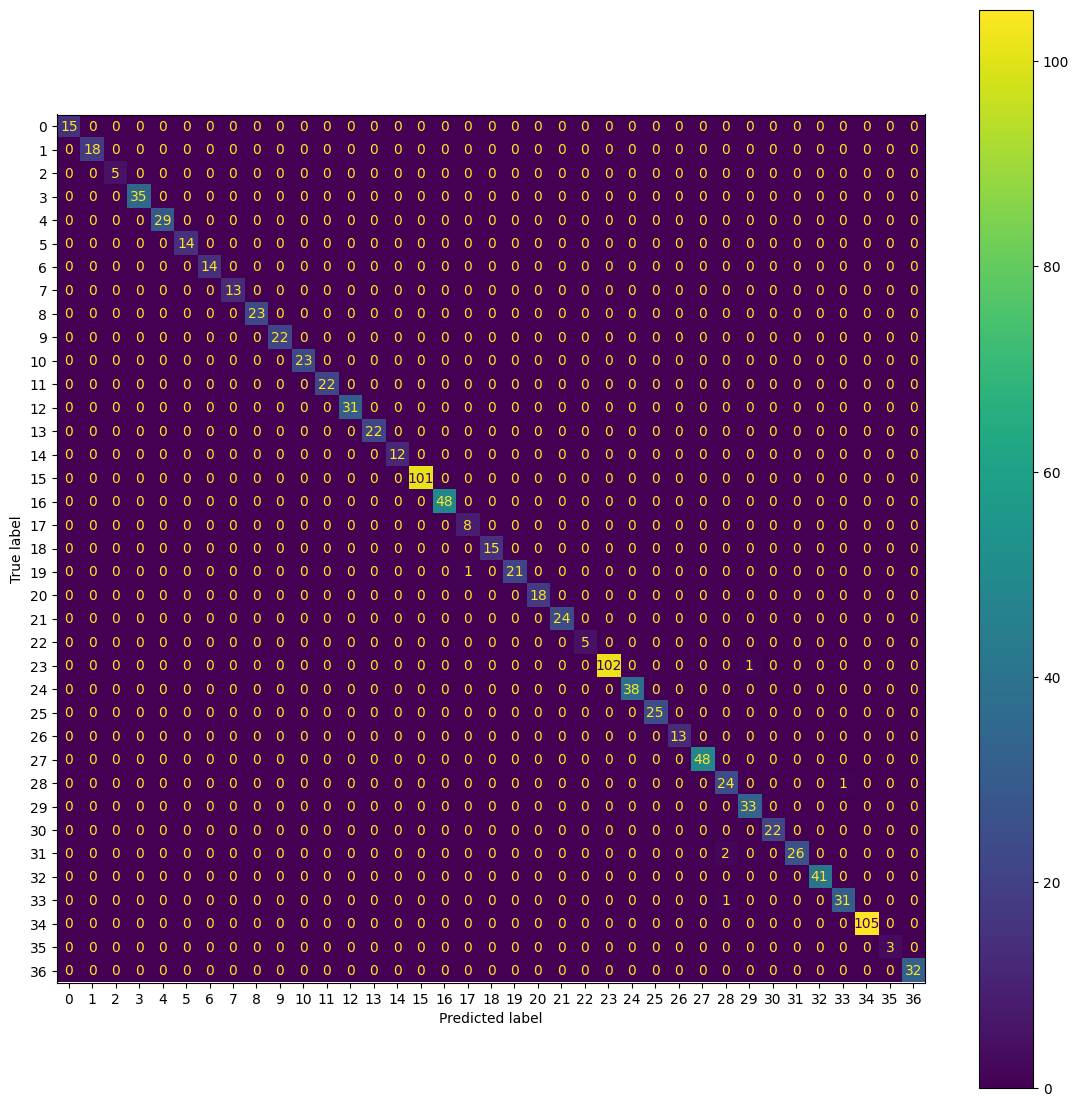

In [22]:
print(f'Test Loss: {test_loss:4f}')
print(f'Test Acc: {test_acc:4f}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
cmp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
fig, ax = plt.subplots(figsize=(14, 14))
cmp.plot(ax=ax)
plt.savefig('resnet25epochs/confusionmatrix.png')

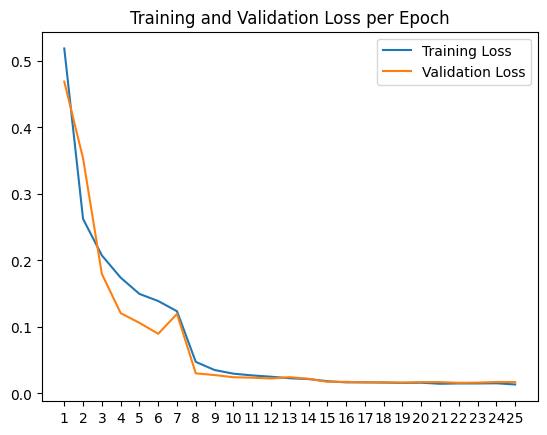

In [23]:
epochs = [i for i in range(1, num_epochs + 1)]
plt.plot(epochs, losses['train'], label="Training Loss")
plt.plot(epochs, losses['val'], label="Validation Loss")
plt.xticks(epochs)
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.savefig('resnet25epochs/loss.png')

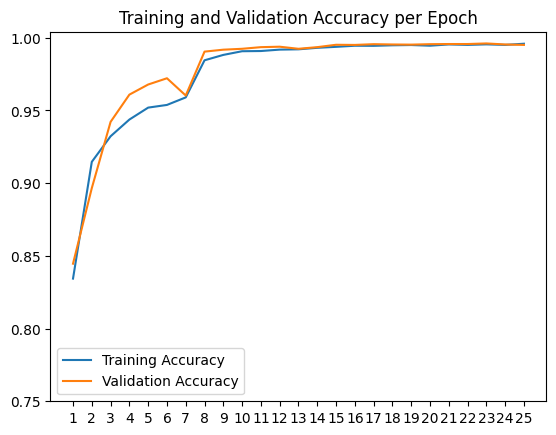

In [29]:
epochs = [i for i in range(1, num_epochs + 1)]
plt.plot(epochs, accs['train'], label="Training Accuracy")
plt.plot(epochs, accs['val'], label="Validation Accuracy")
plt.xticks(epochs)
plt.yticks(np.arange(0.75, 1.02, 0.05))
plt.title("Training and Validation Accuracy per Epoch")
plt.legend()
plt.savefig('resnet25epochs/accuracy.png')

In [30]:
def imshow(inp):
    inp = np.swapaxes(inp, 0, 2)
    inp = np.swapaxes(inp, 0, 1)
    plt.imshow(np.array(inp), vmin=0, vmax=1)

In [33]:
def visualize_model(model, num_images=6):
    model.eval()
    image_count = 0
    fig = plt.figure(figsize=(12, 12))

    with torch.no_grad():
        for _, (inputs, labels) in enumerate(loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                image_count += 1
                ax = plt.subplot(num_images//2, 2, image_count)
                ax.axis('off')
                ax.set_title(f'predicted: {distinct_labels[preds[j]]}')
                imshow(inputs[j].cpu())

                if image_count == num_images:
                    fig.savefig('resnet25epochs/predictions.png', format="png")
                    return

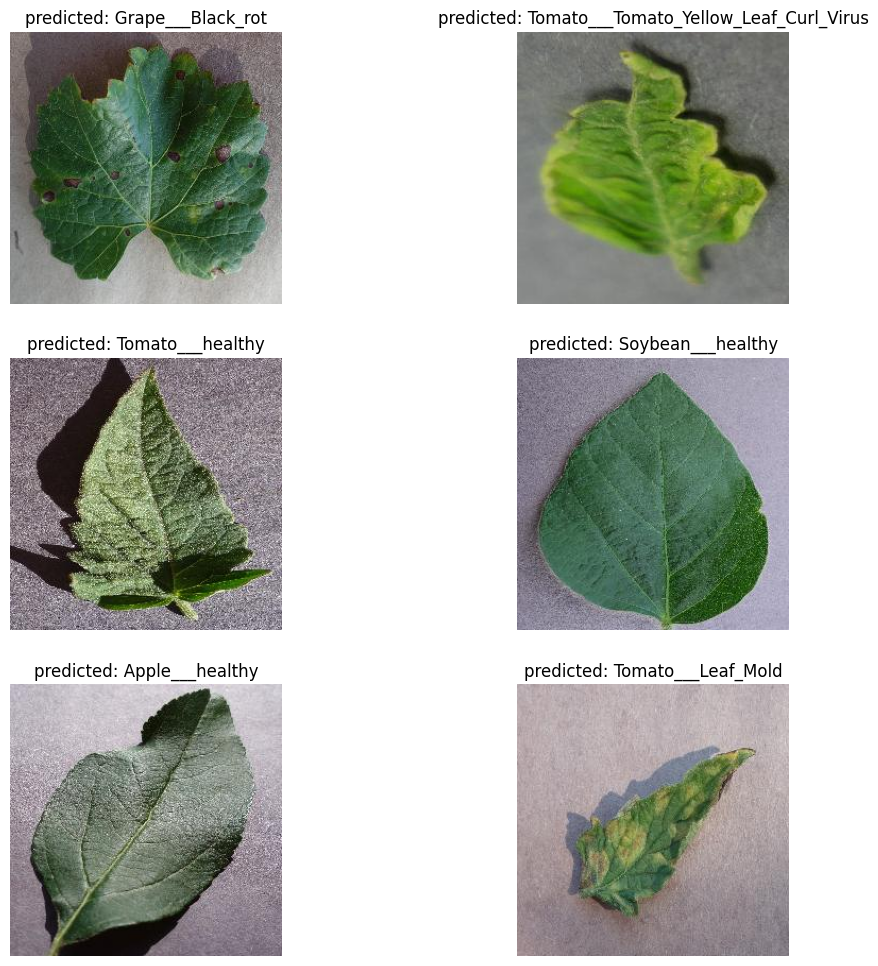

In [34]:
visualize_model(model)